# 1. Data Colletion
Extract zip file downloaded using Kaggle API

In [8]:
import zipfile

with zipfile.ZipFile("loan-prediction-problem-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("loan_data")


Importing the Libraries


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Importing the training Dataset


In [10]:
data = pd.read_csv("loan_data/train_u6lujuX_CVtuZ9i.csv")
data.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [11]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


# 2. Procressing the Dataset

In [13]:
data.isnull().sum() 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Normalizing the data

<Axes: >

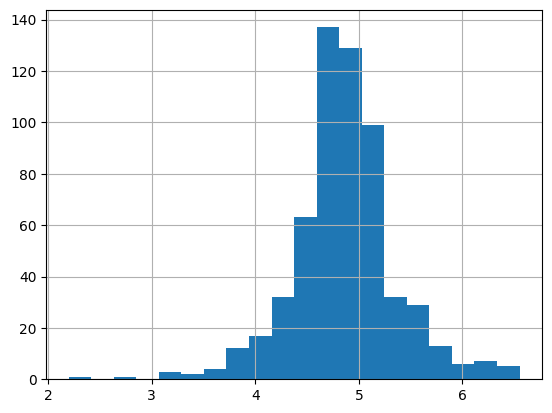

In [14]:
data['loanAmount_log']= np.log(data['LoanAmount']) ## normalising the loan amount and visualizing
data['loanAmount_log'].hist(bins=20)

<Axes: >

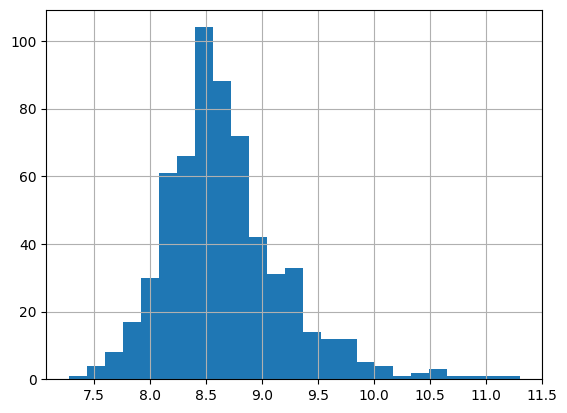

In [15]:
data['totalincome']=data['ApplicantIncome']+data['CoapplicantIncome']  ## making the new attributes
data['totalincome']=np.log(data['totalincome'])  #normalising the new attributes and normalisin g
data['totalincome'].hist(bins=25)

Cleaning and handling the null values

In [16]:
data['Gender'].fillna(data['Gender'].mode()[0], inplace= True)
data['Married'].fillna(data['Married'].mode()[0], inplace= True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace= True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace= True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace= True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace= True)

data.LoanAmount = data.LoanAmount.fillna(data.LoanAmount.mean())
data.loanAmount_log = data.loanAmount_log.fillna(data.loanAmount_log.mean())

data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
loanAmount_log       0
totalincome          0
dtype: int64

In [17]:
data.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,loanAmount_log,totalincome
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,4.857444,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,4.852030,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,4.189655,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4.787492,8.505323
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,4.948760,8.699515
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y,5.587249,9.170872
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,Y,4.553877,8.255569
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,N,5.062595,8.619750
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,Y,5.123964,8.618305
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,N,5.855072,10.077819


Dividing the dataset into Independent and Dependent variables
- x will denote the independent variables
- y will denote the dependent variables

In [18]:
x = data.iloc[:,np.r_[1:5,9:11,13:15]].values
y = data.iloc[:,12].values

In [19]:
x

array([['Male', 'No', '0', ..., 1.0, 4.857444178729352,
        8.674025985443025],
       ['Male', 'Yes', '1', ..., 1.0, 4.852030263919617,
        8.714567550836485],
       ['Male', 'Yes', '0', ..., 1.0, 4.189654742026425,
        8.006367567650246],
       ...,
       ['Male', 'Yes', '1', ..., 1.0, 5.53338948872752,
        9.025455532779063],
       ['Male', 'Yes', '2', ..., 1.0, 5.231108616854587,
        8.933664178700935],
       ['Female', 'No', '0', ..., 0.0, 4.890349128221754,
        8.430109084509125]], shape=(614, 8), dtype=object)

In [20]:
y

array(['Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N',
       'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'N',
       'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'N

# 3. Exploratory Data Analysis

Number of people who take loan as group by Gender: 
Gender
Male      502
Female    112
Name: count, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

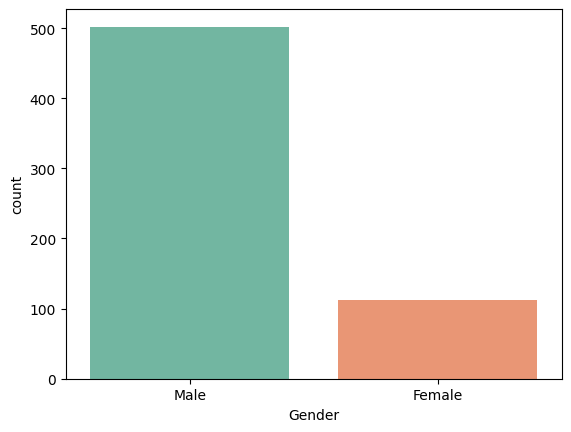

In [21]:
print("Number of people who take loan as group by Gender: ")
print(data['Gender'].value_counts())
sns.countplot(data=data, x="Gender", palette='Set2')

Number of people who take loan as group by Martial Status: 
Married
Yes    401
No     213
Name: count, dtype: int64


<Axes: xlabel='Married', ylabel='count'>

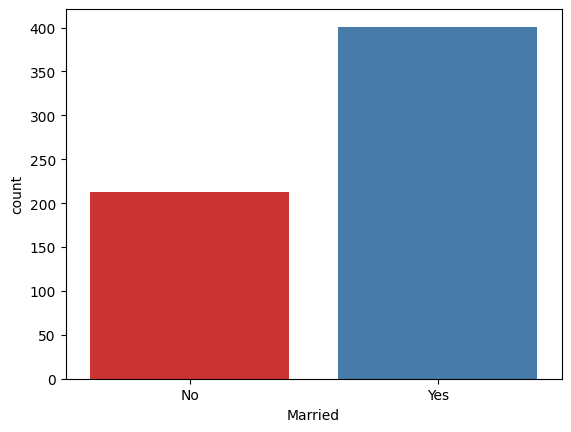

In [22]:
print("Number of people who take loan as group by Martial Status: ")
print(data['Married'].value_counts())
sns.countplot(data=data, x="Married", palette='Set1')

Number of people who take loan as group by Dependents: 
Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64


<Axes: xlabel='Dependents', ylabel='count'>

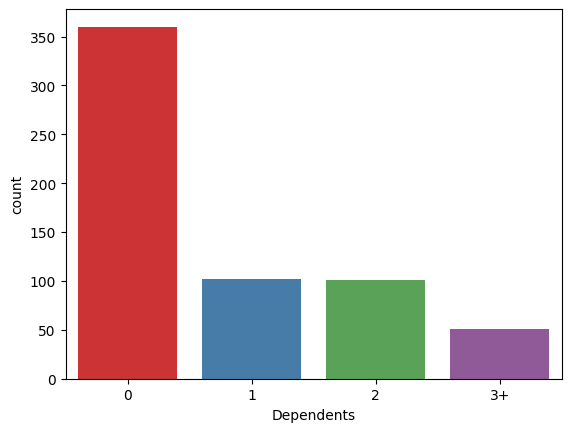

In [23]:
print("Number of people who take loan as group by Dependents: ")
print(data['Dependents'].value_counts())
sns.countplot(data=data, x="Dependents", palette='Set1')

Number of people who take loan as group by Self Employed: 
Self_Employed
No     532
Yes     82
Name: count, dtype: int64


<Axes: xlabel='Self_Employed', ylabel='count'>

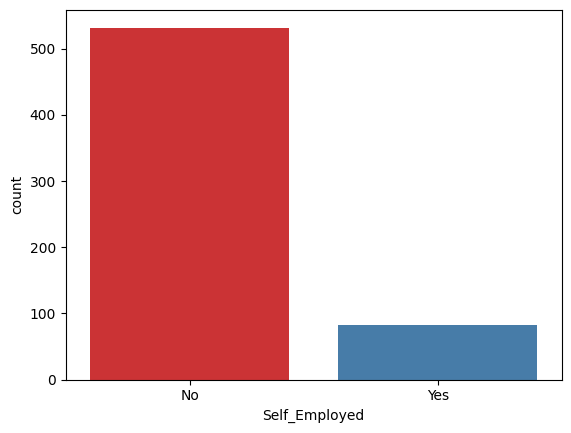

In [24]:
print("Number of people who take loan as group by Self Employed: ")
print(data['Self_Employed'].value_counts())
sns.countplot(data=data, x="Self_Employed", palette='Set1')

Number of people who take loan as group by Loan Amount: 
Loan_Amount_Term
360.0    526
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64


<Axes: xlabel='Loan_Amount_Term', ylabel='count'>

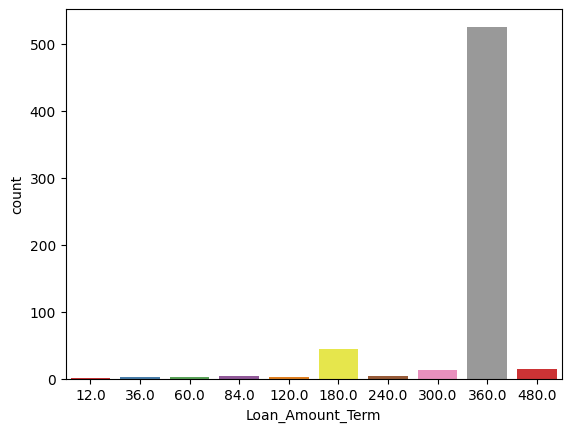

In [25]:
print("Number of people who take loan as group by Loan Amount: ")
print(data['Loan_Amount_Term'].value_counts())
sns.countplot(data=data, x="Loan_Amount_Term", palette='Set1')

Number of people who take loan as group by Credit History: 
Credit_History
1.0    525
0.0     89
Name: count, dtype: int64


<Axes: xlabel='Credit_History', ylabel='count'>

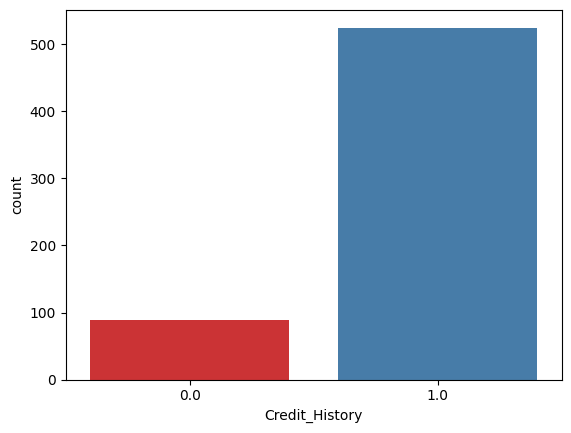

In [26]:
print("Number of people who take loan as group by Credit History: ")
print(data['Credit_History'].value_counts())
sns.countplot(data=data, x="Credit_History", palette='Set1')

## 4. Label Encoding

Test and Train Split

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)


from sklearn.preprocessing import LabelEncoder
labelEncoder_x= LabelEncoder()

In [28]:
for i in range(0, 5):
    X_train[:,i]= labelEncoder_x.fit_transform(X_train[:,i])
    X_train[:,7]= labelEncoder_x.fit_transform(X_train[:,7])
    
X_train

array([[1, 1, 1, ..., 1.0, 3.784189633918261, 235],
       [1, 0, 0, ..., 1.0, 4.836281906951478, 155],
       [1, 0, 2, ..., 1.0, 5.087596335232384, 372],
       ...,
       [1, 1, 3, ..., 1.0, 5.298317366548036, 343],
       [1, 1, 0, ..., 1.0, 5.075173815233827, 258],
       [0, 1, 0, ..., 1.0, 5.204006687076795, 285]],
      shape=(460, 8), dtype=object)

In [29]:
labelEncoder_y= LabelEncoder()
y_train = labelEncoder_y.fit_transform(y_train)

y_train

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,

Testing

In [30]:
for i in range(0, 5):
    X_test[:,i]= labelEncoder_x.fit_transform(X_test[:,i])
    X_test[:,7]= labelEncoder_x.fit_transform(X_test[:,7])
    
X_test 

array([[1, 0, 0, ..., 1.0, 4.430816798843313, 105],
       [0, 0, 0, ..., 1.0, 4.718498871295094, 38],
       [1, 1, 0, ..., 1.0, 5.780743515792329, 127],
       ...,
       [1, 1, 0, ..., 1.0, 4.912654885736052, 132],
       [1, 0, 0, ..., 1.0, 4.882801922586371, 83],
       [1, 1, 1, ..., 0.0, 4.795790545596741, 44]],
      shape=(154, 8), dtype=object)

In [31]:
labelEncoder_y= LabelEncoder()
y_test = labelEncoder_y.fit_transform(y_test)

y_test

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0])

Standardize features by removing the mean and scaling to unit variance.

In [32]:
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.fit_transform(X_test)

To find which classifier is best for the prediction by accuracy
- Using Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_clasifier= RandomForestClassifier()
rf_clasifier.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
from sklearn import metrics
y_pred= rf_clasifier.predict(X_test)

print("According to Random Forest Prediction Percentage is ", metrics.accuracy_score(y_pred, y_test))
y_pred

According to Random Forest Prediction Percentage is  0.7922077922077922


array([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0])

- Using Naive Bayes Classifier

In [35]:
from sklearn.naive_bayes import GaussianNB
NB_CLF= GaussianNB()
NB_CLF.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [36]:
y_pred= NB_CLF.predict(X_test)

print("According to GaussianNB Prediction Percentage is ", metrics.accuracy_score(y_pred, y_test))
y_pred

According to GaussianNB Prediction Percentage is  0.8311688311688312


array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0])

- Using Decision Tree Classifier


In [38]:
from sklearn.tree import DecisionTreeClassifier

DT_CLSIFIER= DecisionTreeClassifier()
DT_CLSIFIER.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [39]:
y_pred= DT_CLSIFIER.predict(X_test)

print("According to DecisionTreeClassifier, Prediction Percentage is ", metrics.accuracy_score(y_pred, y_test))

According to DecisionTreeClassifier, Prediction Percentage is  0.6688311688311688


In [40]:
y_pred

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

- Using KNeighbors Classifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
KN_CLSIFIER= KNeighborsClassifier()
KN_CLSIFIER.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [42]:
y_pred= KN_CLSIFIER.predict(X_test)

print("According to KNeighborsClassifier, Prediction Percentage is ", metrics.accuracy_score(y_pred, y_test))

According to KNeighborsClassifier, Prediction Percentage is  0.8116883116883117
